Test of constructing a PSF-matching kernel via Richardson-Lucy deconvolution
----------

This is a test of how well we might be able to construct a PSF matching kernel using Richardson-Lucy deconvolution (out of the box, with no damping or optimizing of the number of iterations...and with no noise).

 * Take a NIRCAM and a MIRI PSF from the WebbPSF library. 
 * Resample on to the same pixel grid. 
 * Normalize both
 * R-L deconvolve the MIRI PSF by the NIRCAM PSF
 * convolve the NIRCAM PSF by this kernel
 * look at the residuals


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import convolution
from scipy import stats
import lucy
import photutils
from astropy.io import fits
from astropy.nddata import Cutout2D
from scipy.ndimage import zoom
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

In [59]:
datadir='/astro/3/jwst_da_sprint_testdata/psfkernel_sprint/'
nircam = fits.open(datadir+'PSF_NIRCam_F200W_revV-1.fits')[0].data
miri = fits.open(datadir+'PSF_MIRI_F770W_revV-1.fits')[0].data
nircam.shape,miri.shape

((1260, 1260), (728, 728))

In [60]:
nirmir = zoom(nircam,0.007925/0.0275,output=np.float64) # Pixel scales of the NIRCAM/MIRI images

In [61]:
s1 = photutils.morphology.data_properties(nirmir,mask=nirmir>1.e-2)
s2 = photutils.morphology.data_properties(miri,mask=miri>1.e-2)
print s1.centroid,s1.maxval_pos
print s2.centroid,s2.maxval_pos

[ 181.25766858  180.97058239] pix [ 181.  181.] pix
[ 364.21730038  363.00980007] pix [ 363.  364.] pix


In [62]:
nm_s = Cutout2D(nirmir,s1.centroid.value,(75,75)).data
miri_s = Cutout2D(miri,s2.centroid.value,(75,75)).data
nm_s = nm_s/nm_s.sum()
miri_s = miri_s/miri_s.sum()
s1 = photutils.morphology.data_properties(nm_s,mask=None)
s2 = photutils.morphology.data_properties(miri_s,mask=None)
print s1.centroid,s1.maxval_pos
print s2.centroid,s2.maxval_pos

[ 37.19909024  36.89695864] pix [ 37.  37.] pix
[ 38.07911003  36.09492458] pix [ 37.  37.] pix


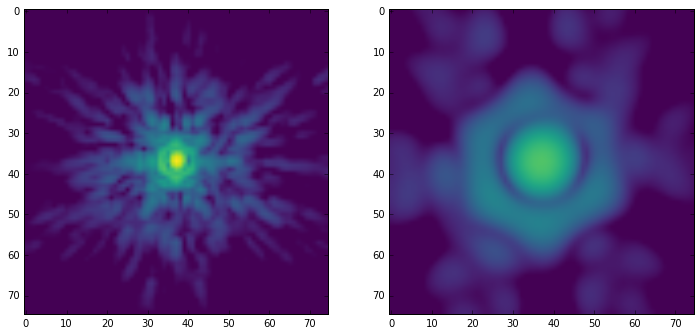

In [63]:
plt.subplot(121)
plt.imshow(np.log10(nm_s),vmin=-5,vmax=-1,cmap=plt.cm.viridis)
plt.subplot(122)
plt.imshow(np.log10(miri_s),vmin=-5,vmax=-1,cmap=plt.cm.viridis)

In [ ]:
kernel = lucy.rl_standard(miri_s,nm_s,100)

In [ ]:
matched = convolution.convolve(nm_s,kernel)
plt.subplot(131)
plt.imshow(np.log10(miri_s),vmin=-5,vmax=-1,cmap=plt.cm.viridis)
plt.subplot(132)
plt.imshow(np.log10(matched.T),vmin=-5,vmax=-1,cmap=plt.cm.viridis)
plt.subplot(133)
resid = matched.T-miri_s
plt.imshow(resid,cmap=plt.cm.viridis)
s2 = photutils.morphology.data_properties(miri_s,mask=None)
sm = photutils.morphology.data_properties(matched,mask=None)
print "mirisigma ",s2.semimajor_axis_sigma,sm.semiminor_axis_sigma
print "matchedsigma ",sm.semimajor_axis_sigma,sm.semiminor_axis_sigma
print "miri centroid",s2.centroid,s2.maxval_pos
print "matched centroid",sm.centroid,sm.maxval_pos

In [ ]:
resid.mean(),np.median(resid),resid.max()